## Imaging 

Testing different kind of imaging. The accuracy on the selection is not the goal here...

In [10]:
using PyCall
using Distributions , Statistics ,  Distances
using Random , Formatting

using PyPlot

rootdir = "/home/stephane/Science/GAIA"

push!(LOAD_PATH,"$rootdir/master/src")
using GaiaClustering

## directory
wdir    = "$rootdir/products"
plotdir = "$rootdir/products/test"

cd(wdir)

In [11]:
## Get the data for a vot file with a standard set for dbscan
## 
function _getcluster(voname)
    data       = read_votable(voname)
    df         = filter_data(data)
    dfcart     = add_cartesian(df)
    blck       = [[1,2,3],[4,5], [6,7,8]]
    wghtblck   = [4.3,7.9,2.0]
    norm       = "identity"

    dfcartnorm , scale8 = normalization_PerBlock(dfcart, blck, wghtblck , norm, false) 
    
    println("## dbscan..")
    eps = 2.1 ; min_nei = 7 ; min_cl = 18
    labels = clusters(dfcartnorm.data , eps , 20, min_nei, min_cl)
    labelmax , nmax = find_cluster_label(labels)
    
    cluster = subsetDf(dfcart , labels[labelmax])
    return(cluster)
end

_getcluster (generic function with 1 method)

In [12]:
function _plot_density(Z , Z2 , xrange , yrange , cmap)
    fig = figure(figsize=(11,4.0))

    ax1 = subplot(121)
    grid("on") 
    nxy = size(Z)
    nlab = 5 ## number of ticks
    im1 = ax1[:imshow](Z, interpolation="bilinear", cmap=cmap )
    xlabel("a1") ; ylabel("a2")
    ax1[:set_xticks](range(1, stop = nxy[1], length = nlab)) 
    ax1[:set_xticklabels](range(xrange[1], stop = xrange[2], length = nlab))
    ax1[:set_yticks](range(1, stop = nxy[2], length = nlab)) 
    ax1[:set_yticklabels](range(yrange[1], stop = yrange[2], length = nlab))   
    ax1[:set_aspect]("auto")
    fig[:colorbar](im1, ax=ax1)
    
    ax2 = subplot(122)
    grid("on") 
    im2 = ax2[:imshow](Z2, interpolation="bilinear", cmap=cmap )
    xlabel("a1") ; ylabel("a2")
    ax2[:set_xticks](range(1, stop = nxy[1], length = nlab)) 
    ax2[:set_xticklabels](range(xrange[1], stop = xrange[2], length = nlab))
    ax2[:set_yticks](range(1, stop = nxy[2], length = nlab)) 
    ax2[:set_yticklabels](range(yrange[1], stop = yrange[2], length = nlab))   
    ax2[:set_aspect]("auto")
    fig[:colorbar](im2, ax=ax2)
    
    show()
end

_plot_density (generic function with 1 method)

In [13]:
## 2D density from 2 Vectors

function _density2D(X , Y , nx , ny, xrange=[0,1] , yrange=[0,1] ; Z = 0)
    dens = zeros(Float64,nx, ny)
    ndata = length(X)
    
    ## simple counting if Z not a X-like vector
    if length(Z) < ndata
        Z = ones(Float64 , ndata)
    end
    
    dx = (xrange[2] - xrange[1]) / nx ; dy = (yrange[2] - yrange[1]) / ny
    
    indx = floor.(Int64 , (X .- xrange[1]) ./ dx)
    indy = floor.(Int64 , (Y .- yrange[1]) ./ dy)
    
    icrop = (indx .>= 1) .& (indx .<= nx) .& (indy .>= 1)  .& (indy .<= ny)

    for i in 1:ndata
        if icrop[i]
            dens[indx[i], indy[i]] += Z[i]
        end
    end
    
    #dens = dens ./ (dx*dy)
    
    return(dens)
end

_density2D (generic function with 3 methods)

In [14]:
## adaptative smoothing to compute the density in counts or averaging value
##

function adaptSmoothing(im , winmax= 10, countstop= 10)
    let
    nxy = size(im)
    cij = 0 
    imas = zeros(Float64, nxy[1] , nxy[2])
    for i in 1:nxy[1]
        for j in 1:nxy[2]  
            snreached = false
            wij = 0
            cij = im[i,j]     
            while !snreached
                if (cij >= countstop) ||  (wij > winmax)
                   snreached =  true
                   cij = cij / (2wij+1)^2
                else
                   cij = sumWindow(im, i , j , wij)
                end
                wij += 2
            end
            imas[i,j] = cij
        end
    end
   
    return(imas)
    end
end

function sumWindow(im, i , j , wij)
    let
    nxy = size(im)
    sum = 0.
    for ki in i-wij:i+wij
        for kj in j-wij:j+wij
            iw = ki ; jw = kj
            if iw <= 0 iw += nxy[1] end
            if jw <= 0 jw += nxy[2] end
            if iw > nxy[1] iw -= nxy[1] end
            if jw > nxy[2] jw -= nxy[2] end
            sum += im[iw,jw]
        end
    end
    
    return(sum)
    end
end

sumWindow (generic function with 1 method)

## Main 

In [15]:
voname = "test.vot"
println("## Main starting...")
s = _getcluster(voname)
    
### density
X = s.data[2,:]  
Y = s.data[3,:]
#X = rand(Float64,1000)
#Y = rand(Float64,1000)
println("## imaging")

## Main starting...
## Votable test.vot read
## Filtering done ...
## Stars selected: 4461
## Cartesian transformation done ...
## Normalization identity done...
### [1pc,1pc,1pc,1km/s,1km/s,1mag,1mag,1mag] equivalent to [0.310092, 0.310092, 0.310092, 0.569703, 0.569703, 0.144229, 0.144229, 0.144229]
##
## dbscan..


787-element Array{Float64,1}:
  3.1646424739327297 
  1.8200686719170167 
  3.117139172079029  
  2.298508331065853  
  2.093790067089897  
  1.7541497052019346 
  1.7836017297623818 
  2.3404444258316177 
  3.500112009297406  
  3.1086949378502267 
  1.4095688279020613 
  3.0916555462770554 
  1.538155944558916  
  ⋮                  
  1.3738656086334784 
 -0.46405715814348947
 -0.5186866230099706 
  1.9088912582979625 
  1.3504703298027996 
  3.5962170695210838 
 -2.391429848611119  
  4.530509516708581  
  1.6279809330434696 
  1.7330754451218373 
  6.363829789409102  
 -3.526415888658547  

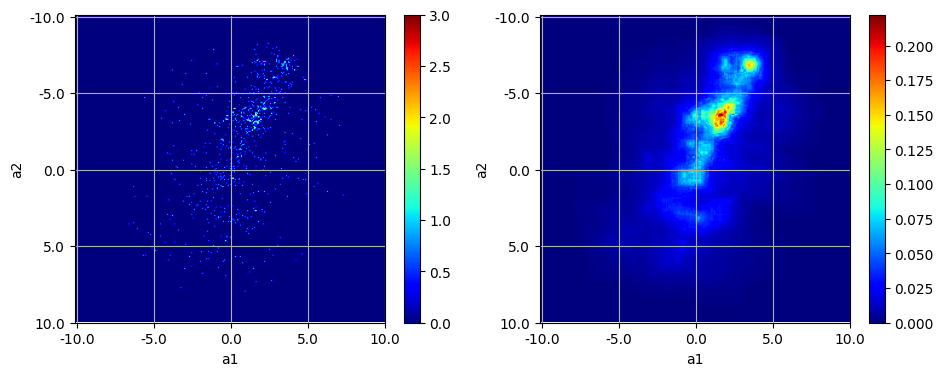

## Main done


In [16]:
dens = _density2D(X , Y , 256 , 256 , [-10 , 10.],[ -10 , 10])
dens2 = adaptSmoothing(dens , 20,  10)
_plot_density(dens , dens2 , [-10,10], [-10,10] ,"jet")

println("## Main done")